In [2]:
pip install rasterio

  Obtaining dependency information for rasterio from https://files.pythonhosted.org/packages/7e/1f/56462740694de764fde264051224fcbf800dad43cac92a66753153128866/rasterio-1.4.3-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for affine from https://files.pythonhosted.org/packages/0b/f7/85273299ab57117850cc0a936c64151171fac4da49bc6fba0dad984a7c5f/affine-2.4.0-py3-none-any.whl.metadata
  Obtaining dependency information for cligj>=0.5 from https://files.pythonhosted.org/packages/73/86/43fa9f15c5b9fb6e82620428827cd3c284aa933431405d1bcf5231ae3d3e/cligj-0.7.2-py3-none-any.whl.metadata
  Obtaining dependency information for click-plugins from https://files.pythonhosted.org/packages/3d/9a/2abecb28ae875e39c8cad711eb1186d8d14eab564705325e77e4e6ab9ae5/click_plugins-1.1.1.2-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/25.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/25.5 MB 991.0 kB/s eta 0:00:26
   ------------------------

In [4]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [7]:
import os
print(os.listdir())


['climate data', 'cmip6 cnrm visualization.ipynb', 'cmip6 to csv.ipynb', 'contourmap comparison.ipynb', 'countyship pvout total comparison.ipynb', 'downloads', 'for cloud update', 'power generation json reading.ipynb', 'power plant x cmip6.ipynb', 'pvout by solargis tif.ipynb', 'seasonal analysis.ipynb', 'simple linear regression.ipynb', 'test import nffile.ipynb', 'township pvout comparison.ipynb', 'township pvout.ipynb']


[DEBUG] Found file: 'DIF.tif'
[DEBUG] Found file: 'DIF.tif.aux.xml'
[DEBUG] Found file: 'DIF.tif.pdf'
[DEBUG] Found file: 'DIF.tif.xml'
[DEBUG] Found file: 'DNI.tif'
[DEBUG] Found file: 'DNI.tif.aux.xml'
[DEBUG] Found file: 'DNI.tif.pdf'
[DEBUG] Found file: 'DNI.tif.xml'
[DEBUG] Found file: 'GHI.tif'
[DEBUG] Found file: 'GHI.tif.aux.xml'
[DEBUG] Found file: 'GHI.tif.pdf'
[DEBUG] Found file: 'GHI.tif.xml'
[DEBUG] Found file: 'GTI.tif'
[DEBUG] Found file: 'GTI.tif.aux.xml'
[DEBUG] Found file: 'GTI.tif.pdf'
[DEBUG] Found file: 'GTI.tif.xml'
[DEBUG] Found file: 'monthly'
[DEBUG] Found file: 'OPTA.tif'
[DEBUG] Found file: 'OPTA.tif.aux.xml'
[DEBUG] Found file: 'OPTA.tif.pdf'
[DEBUG] Found file: 'OPTA.tif.xml'
[DEBUG] Found file: 'PVOUT.tif'
✔ Found: C:\Users\User\Downloads\Taiwan-(China)_GISdata_LTAym_AvgDailyTotals_GlobalSolarAtlas-v2_GEOTIFF\Taiwan_GISdata_LTAy_AvgDailyTotals_GlobalSolarAtlas-v2_GEOTIFF\PVOUT.tif


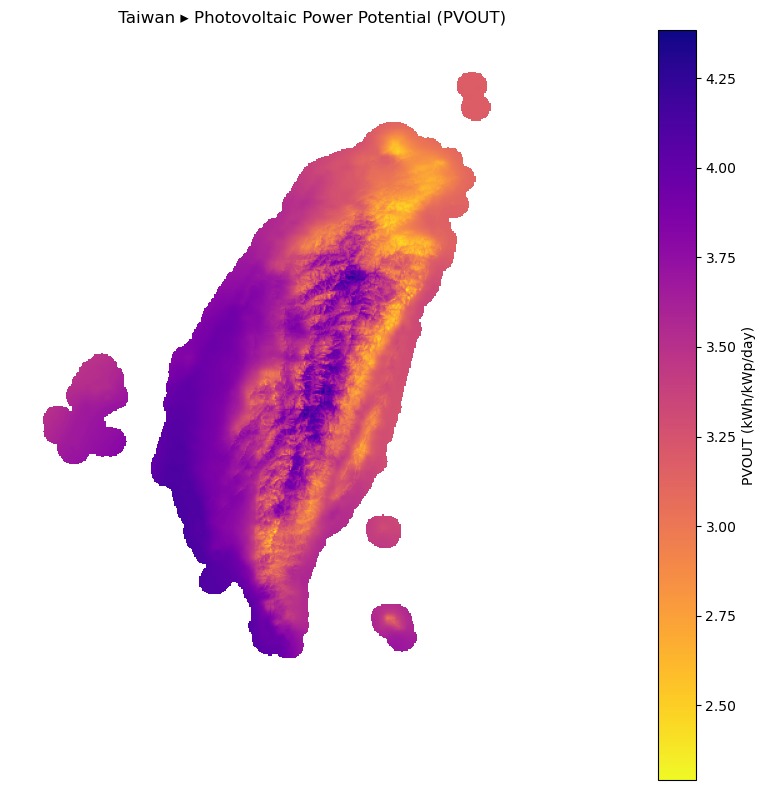

In [4]:
import os
import rasterio
import matplotlib.pyplot as plt

folder = r"C:\Users\User\Downloads\Taiwan-(China)_GISdata_LTAym_AvgDailyTotals_GlobalSolarAtlas-v2_GEOTIFF\Taiwan_GISdata_LTAy_AvgDailyTotals_GlobalSolarAtlas-v2_GEOTIFF"

for fname in os.listdir(folder):
    print(f"[DEBUG] Found file: {fname!r}")  # <- See what it detects

    if "pvout" in fname.lower():  # <- Don't restrict by extension
        tif_path = os.path.join(folder, fname)
        print("✔ Found:", tif_path)

        with rasterio.open(tif_path) as src:
            data = src.read(1)
            plt.figure(figsize=(10, 8))
            plt.imshow(data, cmap="plasma_r")
            plt.colorbar(label="PVOUT (kWh/kWp/day)")
            plt.title(" Taiwan ▸ Photovoltaic Power Potential (PVOUT)")
            plt.axis("off")
            plt.tight_layout()
            plt.show()
        break
else:
    print("❌ PVOUT .tif file not found in folder.")


KeyboardInterrupt: 

Number of records in month 11: 66693


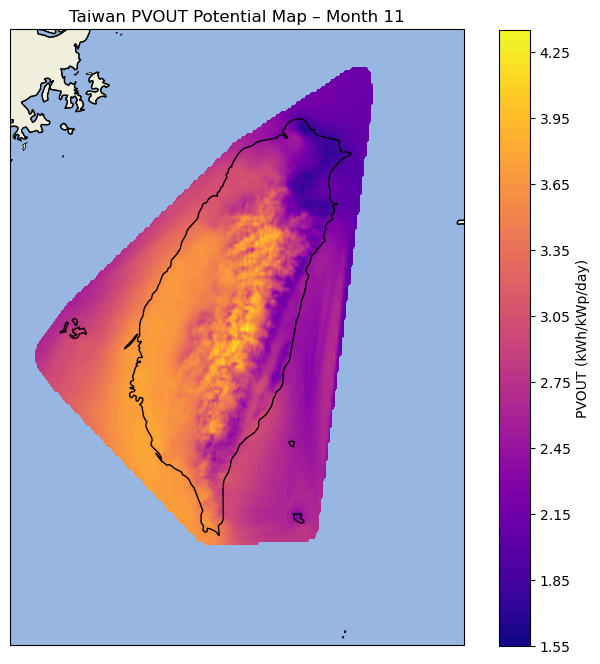

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import griddata

# 1. Load data
df = pd.read_csv(r"C:\Users\User\Downloads\taiwan_pvout_all_months.csv")
df.columns = df.columns.str.strip()

# 2. Set target month (integer 1-12)
target_month = 11

# 3. Filter data for target month
df_filtered = df[df["month"] == target_month]

print(f"Number of records in month {target_month}:", len(df_filtered))

# 4. Drop rows with missing lat, lon, or pvout
df_filtered = df_filtered.dropna(subset=["lat", "lon", "pvout (kWh/kWp/day)"])

# Check if data is available for plotting
if df_filtered.empty:
    print(f"No data available for month {target_month}.")
else:
    # 5. Create grid over Taiwan
    num_points = 200
    lon_grid = np.linspace(119, 123, num_points)
    lat_grid = np.linspace(21, 26, num_points)
    lon2d, lat2d = np.meshgrid(lon_grid, lat_grid)

    # 6. If multiple records per point, aggregate (e.g. mean)
    df_grouped = df_filtered.groupby(["lon", "lat"])["pvout (kWh/kWp/day)"].mean().reset_index()

    # 7. Interpolate pvout onto grid
    points = df_grouped[["lon", "lat"]].values
    values = df_grouped["pvout (kWh/kWp/day)"].values
    grid_pvout = griddata(points, values, (lon2d, lat2d), method='cubic')

    # 8. Plot map
    fig = plt.figure(figsize=(9, 8))
    ax = plt.axes(projection=ccrs.Mercator())
    ax.set_extent([119, 123, 21, 26], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.OCEAN)

    # 9. Plot interpolated pvout values
    cf = ax.contourf(
        lon2d, lat2d, grid_pvout, 60,
        transform=ccrs.PlateCarree(), cmap="plasma"
    )

    # 10. Add colorbar and title
    plt.colorbar(cf, ax=ax, label="PVOUT (kWh/kWp/day)")
    plt.title(f"Taiwan PVOUT Potential Map – Month {target_month}")
    plt.show()


In [2]:
# Use the same tif_path from the previous cell
#resolution check
with rasterio.open(tif_path) as src:
    print("🗺️ CRS (Coordinate Reference System):", src.crs)
    print("📐 Spatial Resolution (degrees):", src.res)
    print("📦 Width x Height (pixels):", src.width, "×", src.height)
    print("🧭 Bounds (lat/lon):", src.bounds)
    print("📄 Number of Bands:", src.count)

🗺️ CRS (Coordinate Reference System): EPSG:4326
📐 Spatial Resolution (degrees): (0.008333333333333333, 0.008333333333333333)
📦 Width x Height (pixels): 480 × 600
🧭 Bounds (lat/lon): BoundingBox(left=119.0, bottom=21.0, right=123.0, top=26.0)
📄 Number of Bands: 1


In [5]:
#tif to csv
import os
import rasterio
import pandas as pd
from rasterio.transform import xy
import numpy as np

folder = r"C:\Users\User\Downloads\Taiwan-(China)_GISdata_LTAym_AvgDailyTotals_GlobalSolarAtlas-v2_GEOTIFF\Taiwan_GISdata_LTAy_AvgDailyTotals_GlobalSolarAtlas-v2_GEOTIFF"
#the working ones
for fname in os.listdir(folder):
    if "pvout" in fname.lower() and fname.lower().endswith(".tif"):
        tif_path = os.path.join(folder, fname)
        print("✔ Found:", tif_path)

        with rasterio.open(tif_path) as src:
            data = src.read(1, masked=False)  # Don't auto-mask
            transform = src.transform
            nodata = src.nodata
            print("NoData value:", nodata)
            print("First 10 values:", data.flatten()[:10])
            print("Min/Max:", np.nanmin(data), "/", np.nanmax(data))

            rows, cols = data.shape
            lat_list, lon_list, pvout_list = [], [], []

            for row in range(rows):
                for col in range(cols):
                    value = data[row, col]
                    if pd.isna(value) or (nodata is not None and value == nodata):
                        continue
                    lon, lat = xy(transform, row, col, offset="center")
                    lat_list.append(lat)
                    lon_list.append(lon)
                    pvout_list.append(value)

        df = pd.DataFrame({
            "lat": lat_list,
            "lon": lon_list,
            "pvout": pvout_list
        })

        output_path = os.path.join(folder, "taiwan_pvout_data.csv")
        df.to_csv(output_path, index=False)
        print("✅ CSV saved at:", output_path)
        break
else:
    print("❌ PVOUT .tif file not found.")


AttributeError: partially initialized module 'pandas' has no attribute 'core' (most likely due to a circular import)

In [1]:
import os
import rasterio
import pandas as pd
from rasterio.transform import xy
import numpy as np

# Folder containing monthly PVOUT GeoTIFFs
folder = r"C:\Users\User\Downloads\Taiwan-(China)_GISdata_LTAym_AvgDailyTotals_GlobalSolarAtlas-v2_GEOTIFF\Taiwan_GISdata_LTAy_AvgDailyTotals_GlobalSolarAtlas-v2_GEOTIFF\monthly"

# Initialize list to collect monthly DataFrames
df_list = []

# Loop through each month (01 to 12)
for month in range(1, 13):
    month_str = str(month).zfill(2)
    fname = f"PVOUT_{month_str}.tif"
    tif_path = os.path.join(folder, fname)

    if os.path.exists(tif_path):
        print(f"✔ Processing: {tif_path}")

        with rasterio.open(tif_path) as src:
            data = src.read(1, masked=False)
            transform = src.transform
            nodata = src.nodata

            rows, cols = data.shape
            lat_list, lon_list, pvout_list, month_list = [], [], [], []

            for row in range(rows):
                for col in range(cols):
                    value = data[row, col]
                    if pd.isna(value) or (nodata is not None and value == nodata):
                        continue
                    lon, lat = xy(transform, row, col, offset="center")
                    lat_list.append(lat)
                    lon_list.append(lon)
                    pvout_list.append(value)
                    month_list.append(month)  # Add month indicator

            df_month = pd.DataFrame({
                "lat": lat_list,
                "lon": lon_list,
                "pvout (kWh/kWp/day)": pvout_list,
                "month": month_list
            })

            df_list.append(df_month)

    else:
        print(f"❌ File not found: {tif_path}")

# Combine all monthly DataFrames into one
if df_list:
    df_all = pd.concat(df_list, ignore_index=True)
    output_path = os.path.join(folder, "taiwan_pvout_all_months.csv")
    df_all.to_csv(output_path, index=False, encoding='utf-8-sig')
    print(f"✅ All months combined and saved to: {output_path}")
else:
    print("❌ No PVOUT files processed.")


✔ Processing: C:\Users\User\Downloads\Taiwan-(China)_GISdata_LTAym_AvgDailyTotals_GlobalSolarAtlas-v2_GEOTIFF\Taiwan_GISdata_LTAy_AvgDailyTotals_GlobalSolarAtlas-v2_GEOTIFF\monthly\PVOUT_01.tif
✔ Processing: C:\Users\User\Downloads\Taiwan-(China)_GISdata_LTAym_AvgDailyTotals_GlobalSolarAtlas-v2_GEOTIFF\Taiwan_GISdata_LTAy_AvgDailyTotals_GlobalSolarAtlas-v2_GEOTIFF\monthly\PVOUT_02.tif
✔ Processing: C:\Users\User\Downloads\Taiwan-(China)_GISdata_LTAym_AvgDailyTotals_GlobalSolarAtlas-v2_GEOTIFF\Taiwan_GISdata_LTAy_AvgDailyTotals_GlobalSolarAtlas-v2_GEOTIFF\monthly\PVOUT_03.tif
✔ Processing: C:\Users\User\Downloads\Taiwan-(China)_GISdata_LTAym_AvgDailyTotals_GlobalSolarAtlas-v2_GEOTIFF\Taiwan_GISdata_LTAy_AvgDailyTotals_GlobalSolarAtlas-v2_GEOTIFF\monthly\PVOUT_04.tif
✔ Processing: C:\Users\User\Downloads\Taiwan-(China)_GISdata_LTAym_AvgDailyTotals_GlobalSolarAtlas-v2_GEOTIFF\Taiwan_GISdata_LTAy_AvgDailyTotals_GlobalSolarAtlas-v2_GEOTIFF\monthly\PVOUT_05.tif
✔ Processing: C:\Users\User\Do